# Training and Making predicting

## Description

**8 Models considered:**

For Penelized linear models: Lasso, Ridge, Elastic Net regression 

For Linear dimension reduction tech: PCR, partial least squares regressions 

For Nonlinear models: RF, gradient boosted tree regression (GBR), gradient boosted tree regression with dropout (Dart), deep feed=forward neural networks (FFN)

**Assessing predictive power:**

standard out-of-sample $R^2$ statistic

$$
R^2_{OS} = 1 - \frac{\sum_{(i,t)\in T_3} (r_{i, s, t+1} 
            - \hat{r}_{i,s,t+1})^2} {\sum_{(i,t)\in T_3 r^2_{i, s,t+1}}}
$$

**Four Periods:**

$T_1$ (1996/01 -- 2000/12) -> training

$T_2$ (2001 -- 2002) -> *hyperparameter* optimization **validating**

$T_3$ (2003) -> **testing**

> We repeat this procedure for each year in the testing sample from 2003 through 2020, increasing the number of training years by one at each iteration.

That is: 
* First iteration: 1996 ~ 2000 as train, 2001 ~ 2002 as validate, 2003 as test 

* Second iteration: 1996 ~ 2001 as train, 2002 ~ 2003 as validate, 2004 as test 

... 

* i-th iteration: 1996 ~ 2000 + i-1 as train, 2000 + i ~ 2000 + i+1 as validation, 2000 + i+2 as test

***QUESTION*** How the reported $R^2$ or $R^2_{OS,XS}$ is estimated, since we are running training-validation-testing procedure on multiple periods? 

**Cross sectional asset pricing test**

> In cross-sectional asset pricing tests, our main objective is not to forecast time-series variation in future returns, but rather cross-sectional return spreads in the testing sample.

Han et al (2021) proposes a cross-sectional out-of-sample $R^2$:

$$
R^2_{OS; XS} = 1 - \frac{\sum_{(i,t)\in T_3} [(r_{i,s,t+1} - \bar{r}_{i,s,t+1}) - (\hat{r}_{i,s,t+1} - \bar{\hat{r}}_{i,s,t+1})]^2} 
{\sum_{(i,t)\in T_3} (r_{i,s,t+1} - \bar{r}_{i,s,t+1})^2}
$$

> $R^2_{OS; XS}$ focuses on relative expected returns across options, for which accurate predictions result in profitable long-short trading strategies.

**Statistical significance of models forecasts**

**1. CW test (for individual model)**

$$
CW^{(j)} = \frac{\bar{c}^{(j)}}  {\hat{\sigma}_c^{(j)}}
$$

where $\bar{c}^{(j)}$ is the time series average, and $\hat{\sigma}_c^{(j)}$ is the Newey and West 
standard error ***of*** the mean difference squared forecast errors: 

$$
c_{t+1}^{(j)} = \frac{1}{n_{T_3}} \sum_{(i,t)\in T_3} [r_{i,s,t+1}^2 - (\hat{e}_{i,t+1}^{(j)})^2]
$$

where $n_{T_3}$ is the number of observations in the testing sample and $\hat{e}_{i,t+1}$ is the 
forecast error on option i at time t+1 for method j. 

**2. DM test (for comparison)**

Diebold and Mariano (1995) (DM) test

The DM test-statisics for a comparison between methods 1 and 2 is defined as: 

$$
DM^{(1,2)} = \frac{\bar{d}^{(1,2)}} {\hat{\sigma}_d^{(1,2)}}
$$

where $\bar{d}^{(1,2)}$ is the time series average, and $\hat{\sigma}_d^{(1,2)}$ is the Newey and West 
standard error ***of*** the mean difference squared forecast errors: 

$$
d^{(1,2)}_{t+1} = \frac{1}{n_{T_3}} \sum_{(i,t)\in T_3} [(\hat{e}^{(1)}_{i, t+1})^2 - (\hat{e}^{(2)}_{i, t+1})^2]
$$


In [2]:
import numpy as np
import datetime as dt

from evaluation_metrics import CW_test, DM_test, R_squared_OSXS

import pandas as pd 
import os


In [3]:
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit([[1, 2], [np.nan, 3], [7, 6]])

X = [[np.nan, 2], [6, np.nan], [7, 6]]

imp.transform(X)

array([[4.        , 2.        ],
       [6.        , 3.66666667],
       [7.        , 6.        ]])

## Import data

In [4]:
DATAROOT = "data/"

In [5]:
option_with_feature = pd.read_csv(os.path.join(DATAROOT, "option_with_nonsparse_features.csv"))

In [53]:
option_with_feature = option_with_feature[~option_with_feature.option_ret.isna()]

In [54]:
total_row_num = option_with_feature.shape[0]
# option_with_feature = option_with_feature.dropna()
# print(f"number of na rows: {total_row_num - option_with_feature.shape[0]}")

In [55]:
total_row_num

3981898

In [56]:
option_with_feature["date_x"] = option_with_feature.date_x.apply(lambda x: dt.datetime.strptime(x.split()[0], "%Y-%m-%d")).copy()

AttributeError: 'Timestamp' object has no attribute 'split'

In [57]:
option_with_feature["cp_flag_encoded"] = option_with_feature["cp_flag"].apply(lambda x: {"P": 0, "C": 1}[x])

In [58]:
option_with_feature.sample(3)

,Unnamed: 0,secid,date_x,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,...,PriceDelayRsq,PriceDelaySlope,PriceDelayTstat,ReturnSkew,ReturnSkew3F,VolMkt,zerotrade,zerotradeAlt1,date_y,cp_flag_encoded
274789,274789,106595,2000-05-31,2000-12-16 00:00:00,P,70.0,25.625,26.125,7,274,...,0.060991,-1.442144,3.476541,-0.655572,0.371303,-0.496454,4.056570e-09,3.674683e-09,2000-05-01,0
1364641,1364641,110337,2010-01-29,2010-05-22 00:00:00,P,30.0,0.600,0.650,26,1135,...,0.045057,0.169043,1.405088,0.126718,-0.215996,-0.118171,1.836249e-08,1.649014e-08,2010-01-01,0
1698928,1698928,124758,2012-09-28,2012-11-17 00:00:00,P,210.0,5.500,5.650,8,626,...,0.040684,-0.754100,4.078746,-0.059801,0.020356,-0.455071,5.004222e-09,4.835528e-09,2012-09-01,0


In [59]:
year = 1996
begin_date = dt.datetime.strptime(f"{year}-01-01", "%Y-%m-%d")
end_date = dt.datetime.strptime(f"{year+4}-12-31", "%Y-%m-%d")
training_data = option_with_feature[
    option_with_feature.date_x.between(begin_date, end_date)
]


In [60]:
def train_validation_test_split(option_with_feature, year):
    begin_date = dt.datetime.strptime(f"{year}-01-01", "%Y-%m-%d")
    end_date = dt.datetime.strptime(f"{year+4}-12-31", "%Y-%m-%d")
    training_data = option_with_feature[
        option_with_feature.date_x.between(begin_date, end_date)
    ]

    begin_date = dt.datetime.strptime(f"{year+5}-01-01", "%Y-%m-%d")
    end_date = dt.datetime.strptime(f"{year+6}-12-31", "%Y-%m-%d")
    validation_data = option_with_feature[
        option_with_feature.date_x.between(begin_date, end_date)
    ]

    begin_date = dt.datetime.strptime(f"{year+7}-01-01", "%Y-%m-%d")
    end_date = dt.datetime.strptime(f"{year+7}-12-31", "%Y-%m-%d")
    test_data = option_with_feature[
        option_with_feature.date_x.between(begin_date, end_date)
    ]
    
    return training_data, validation_data, test_data

In [ ]:
# suppress the warning of 
#   "A value is trying to be set on a copy of a slice from a DataFrame. 
#   Try using .loc[row_indexer,col_indexer] = value instead"
pd.options.mode.chained_assignment = None 

mean_squared_errors = []
r2_scores = []
R_squared_OSXS_s = []

for year in range(1996, 2020-7):
    training_data, validation_data, test_data = train_validation_test_split(option_with_feature, year)
    
    used_characteristics = ['volume', 'ReturnSkew', 'MaxRet', 'delta', 'PriceDelaySlope', 'strike_price', 
                        'IdioVol3F', 'ReturnSkew3F', 'ir_rate', 'mid_price', 'forwardprice', 
                        'zerotradeAlt1', 'theta', 'cfadj', 'zerotrade', 'best_bid', 'spotprice', 'VolMkt', 
                        'IdioRisk', 'days_to_exp', 'PriceDelayTstat', 'High52', 'Coskewness', 'BidAskSpread', 
                        'Beta', 'days_no_trading', 'open_interest', 'impl_volatility', 'PriceDelayRsq', 'IdioVolAHT', 
                        'adj_spot', 'vega', 'gamma', 'best_offer', 'DolVol', 'cp_flag_encoded']

    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(training_data[used_characteristics])
    training_data.loc[:, used_characteristics] = imp.transform(training_data[used_characteristics])
    validation_data.loc[:, used_characteristics] = imp.transform(validation_data[used_characteristics])
    test_data.loc[:, used_characteristics] = imp.transform(test_data[used_characteristics])

    X_train = training_data[used_characteristics + ["date_x", "optionid"] ]
    y_train = training_data['option_ret']
    
    X_val = validation_data[used_characteristics + ["date_x", "optionid"] ]
    y_val = validation_data['option_ret']

    X_test = test_data[used_characteristics + ["date_x", "optionid"]]
    y_test = test_data['option_ret']
    

    # tuning hyperparameter on validation set
    best_alpha = 0.1
    best_r2_score = None
    for alpha in [0.01, 0.1, 0.5, 1, 5]:
        reg = linear_model.Lasso(random_state=0, alpha=best_alpha)
        reg.fit(X_train[used_characteristics], y_train)
        y_pred = reg.predict(X_val[used_characteristics])
        r2_score_ = r2_score(y_val, y_pred)
        if best_r2_score is None or r2_score_ > best_r2_score:
            best_alpha = alpha 
            best_r2_score = r2_score_
    print(f"best_alpha: {best_alpha}")
    # regression    
    reg = linear_model.Lasso(random_state=0, alpha=best_alpha)
    reg.fit(X_train[used_characteristics], y_train)
    y_pred = reg.predict(X_test[used_characteristics])
    mean_squared_errors.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    R_squared_OSXS_s.append(R_squared_OSXS(y_test, y_pred))
    print(year, mean_squared_errors[-1], r2_scores[-1], R_squared_OSXS_s[-1])
    

/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.022e+06, tolerance: 3.036e+04
  model = cd_fast.enet_coordinate_descent(
/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.022e+06, tolerance: 3.036e+04
  model = cd_fast.enet_coordinate_descent(
/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

best_alpha: 0.01


/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.022e+06, tolerance: 3.036e+04
  model = cd_fast.enet_coordinate_descent(


1996 166.76980956051264 -0.00030985500631475205 -0.00018974126755910703
best_alpha: 0.01
1997 9.527369188423148 -0.0022886352095055074 -0.002287908881796419


/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e+07, tolerance: 3.003e+04
  model = cd_fast.enet_coordinate_descent(
/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e+07, tolerance: 3.003e+04
  model = cd_fast.enet_coordinate_descent(
/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

best_alpha: 0.01


/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e+07, tolerance: 3.003e+04
  model = cd_fast.enet_coordinate_descent(


1998 237.72856970328567 3.760294894639138e-05 6.788252116152194e-05


/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.244e+05, tolerance: 2.858e+04
  model = cd_fast.enet_coordinate_descent(


best_alpha: 0.1
1999 108.3464190704547 -6.924315263412417e-05 -4.005933637030168e-05
best_alpha: 0.01
2000 198.34659270379444 -0.00021006109287569075 -0.000125477467088686
best_alpha: 0.01
2001 159.11894204727574 9.148912340795068e-05 0.00013397727607622478
best_alpha: 0.1
2002 54.26285501993854 1.4720226684250548e-06 5.744248232741889e-06
best_alpha: 0.01
2003 2170.265862511556 -1.7956905667970702e-05 -7.000226793119069e-06


/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e+07, tolerance: 9.607e+03
  model = cd_fast.enet_coordinate_descent(
/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e+07, tolerance: 9.607e+03
  model = cd_fast.enet_coordinate_descent(
/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

In [289]:
reg.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': 0,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

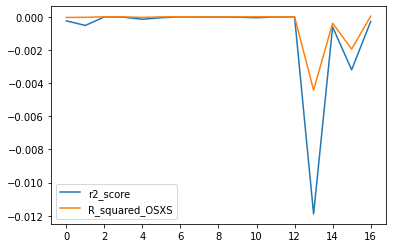

In [288]:
plt.plot(r2_scores)
plt.plot(R_squared_OSXS_s)
plt.legend(["r2_score", "R_squared_OSXS"])

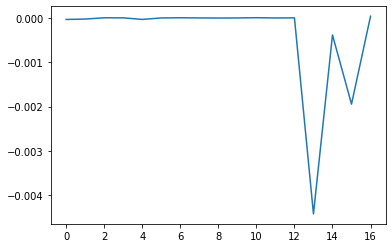

In [60]:
training_data, validation_data, test_data = train_validation_test_split(option_with_feature, 1996)

In [61]:
training_data.shape[0], validation_data.shape[0], test_data.shape[0]

(336797, 153810, 77333)

In [62]:
len(test_data.optionid), len(set(test_data.optionid))

(77333, 39123)

In [63]:
option_with_feature.columns

Index(['Unnamed: 0', 'secid', 'date_x', 'exdate', 'cp_flag', 'strike_price',
       'best_bid', 'best_offer', 'volume', 'open_interest', 'impl_volatility',
       'delta', 'gamma', 'vega', 'theta', 'optionid', 'cfadj',
       'days_no_trading', 'days_to_exp', 'forwardprice', 'spotprice',
       'adj_spot', 'ir_rate', 'mid_price', 'option_ret', 'sdate', 'edate',
       'permno', 'date2', 'yyyymm', 'Beta', 'BidAskSpread', 'Coskewness',
       'DolVol', 'High52', 'IdioRisk', 'IdioVol3F', 'IdioVolAHT', 'MaxRet',
       'PriceDelayRsq', 'PriceDelaySlope', 'PriceDelayTstat', 'ReturnSkew',
       'ReturnSkew3F', 'VolMkt', 'zerotrade', 'zerotradeAlt1', 'date_y',
       'cp_flag_encoded'],
      dtype='object')

In [206]:
used_characteristics = ['volume', 'ReturnSkew', 'MaxRet', 'delta', 'PriceDelaySlope', 'strike_price', 
                        'IdioVol3F', 'ReturnSkew3F', 'ir_rate', 'mid_price', 'forwardprice', 
                        'zerotradeAlt1', 'theta', 'cfadj', 'zerotrade', 'best_bid', 'spotprice', 'VolMkt', 
                        'IdioRisk', 'days_to_exp', 'PriceDelayTstat', 'High52', 'Coskewness', 'BidAskSpread', 
                        'Beta', 'days_no_trading', 'open_interest', 'impl_volatility', 'PriceDelayRsq', 'IdioVolAHT', 
                        'adj_spot', 'vega', 'gamma', 'best_offer', 'DolVol', 'cp_flag_encoded']

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(training_data[used_characteristics])
training_data.loc[:, used_characteristics] = imp.transform(training_data[used_characteristics])
test_data.loc[:, used_characteristics] = imp.transform(test_data[used_characteristics])

X_train = training_data[used_characteristics + ["date_x", "optionid"] ]
y_train = training_data['option_ret']

X_test = test_data[used_characteristics + ["date_x", "optionid"]]
y_test = test_data['option_ret']


# X_train.loc[:, used_characteristics] = imp.transform(X_train[used_characteristics])
# X_test.loc[:, used_characteristics]  = imp.transform(X_test[used_characteristics])

# for char in ["date_x", "optionid"]:
    # X_train[char] = training_data[char]
    # X_test[char]  = test_data[char]

/var/folders/nh/s3ft86ks12xd4qdptmv1pvtc0000gn/T/ipykernel_63350/178259893.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.loc[:, used_characteristics] = imp.transform(training_data[used_characteristics])
/var/folders/nh/s3ft86ks12xd4qdptmv1pvtc0000gn/T/ipykernel_63350/178259893.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, used_characteristics] = imp.transform(test_data[used_characteristics])


In [167]:
training_data["optionid"].shape, training_data["optionid"].dropna().shape
# training_data["date_x"].shape, training_data["date_x"].dropna().shape

((336797,), (336797,))

In [168]:
X_train.shape, X_train["optionid"].dropna().shape, (~X_train["optionid"].isna()).sum()

((336797, 39),
 (336797, 2),
 optionid    336797
 optionid    336797
 dtype: int64)

In [169]:
y_train.shape, y_train.dropna().shape

((336797,), (336797,))

In [170]:
X_train[used_characteristics].shape, X_train[used_characteristics].dropna().shape

((336797, 38), (336797, 38))

In [171]:
X_train[X_train.isnull().any(axis=1)]

,volume,ReturnSkew,MaxRet,delta,PriceDelaySlope,strike_price,IdioVol3F,ReturnSkew3F,optionid,ir_rate,...,PriceDelayRsq,IdioVolAHT,adj_spot,vega,gamma,best_offer,DolVol,cp_flag_encoded,date_x,optionid


## Linear regression

In [211]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [212]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [213]:
from sklearn import linear_model

### Ridge

In [214]:
ridge_reg = linear_model.Ridge()
ridge_reg.fit(X_train[used_characteristics], y_train)

Ridge()

In [215]:
y_pred = ridge_reg.predict(X_test[used_characteristics])

In [216]:
mean_squared_error(y_test, y_pred)

168.56600934104534

In [217]:
r2_score(y_test, y_pred)

-0.011083725569350333

In [218]:
R_squared_OSXS(y_test, y_pred)

-0.00041120131518823655

### Lasso

In [219]:
lasso_reg = linear_model.Lasso()
lasso_reg.fit(X_train[used_characteristics], y_train)

Lasso()

In [220]:
y_pred = lasso_reg.predict(X_test[used_characteristics])

In [221]:
mean_squared_error(y_test, y_pred)

166.7580121954417

In [222]:
r2_score(y_test, y_pred)

-0.00023909267484323316

In [223]:
R_squared_OSXS(y_test, y_pred)

-3.5643609293645184e-05

In [224]:
# CW test

In [225]:
X_test.optionid

490631    20832089
490632    21386851
490633    20387393
490634    54376425
490635    21340061
            ...   
567968    21201673
567969    21259046
567970    21224605
567971    21233682
567972    21247326
Name: optionid, Length: 77333, dtype: int64

In [226]:
true_pred_return = pd.DataFrame(
    {
        "optionid": X_test.optionid,
        "time": X_test.date_x,
        "true_return": y_test,
        "pred_return": y_pred
    }
)

In [227]:
CW_test(true_pred_return)

-0.007289892035047285

In [228]:
# DW test

In [229]:
d = 1 / true_pred_1vs2_return.shape[0] * true_pred_1vs2_return.groupby(["optionid", "time"]).apply(
    lambda group:
    sum(
        np.power(group["true_return"] - group["pred_return1"], 2)
    - np.power(group["true_return"] - group["pred_return2"], 2)
    )
)

NameError: name 'true_pred_1vs2_return' is not defined

In [230]:
np.mean(d) / np.std(d)

NameError: name 'd' is not defined

In [136]:
np.mean(c)

-2.781837086300935e-06

### ElasticNet

combines L1 and L2 punishment term

In [267]:
from sklearn.linear_model import ElasticNet

In [271]:
elastic_reg = ElasticNet()
elastic_reg.fit(X_train[used_characteristics], y_train)

ElasticNet()

In [272]:
y_pred = elastic_reg.predict(X_test[used_characteristics])

In [273]:
mean_squared_error(y_test, y_pred)

166.76262587885864

In [274]:
r2_score(y_test, y_pred)

-0.0002667662268007742

In [275]:
R_squared_OSXS(y_test, y_pred)

-4.74421254630375e-05

## Emsemble models

### GBR

In [240]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

In [241]:
import sklearn
sklearn.__version__

'1.0.2'

In [242]:
gbr_reg = GradientBoostingRegressor(
    n_estimators=100, random_state=0,
    loss='huber',
    verbose=1
).fit(X_train[used_characteristics], y_train)

      Iter       Train Loss   Remaining Time 
         1           0.3957            3.50m
         2           0.3944            3.55m
         3           0.3933            3.44m
         4           0.3911            3.37m
         5           0.3898            3.33m
         6           0.3886            3.28m
         7           0.3876            3.24m
         8           0.3865            3.20m
         9           0.3856            3.15m
        10           0.3849            3.13m
        20           0.3795            2.78m
        30           0.3766            2.48m
        40           0.3742            2.12m
        50           0.3724            1.77m
        60           0.3711            1.42m
        70           0.3698            1.06m
        80           0.3687           42.10s
        90           0.3679           21.01s
       100           0.3670            0.00s


In [244]:
y_pred = gbr_reg.predict(X_test[used_characteristics])

In [245]:
mean_squared_error(y_test, y_pred)

166.72515602566457

In [246]:
r2_score(y_test, y_pred)

-4.2016534308908504e-05

In [247]:
R_squared_OSXS(y_test, y_pred)

-4.1556473954873496e-05

<AxesSubplot:>

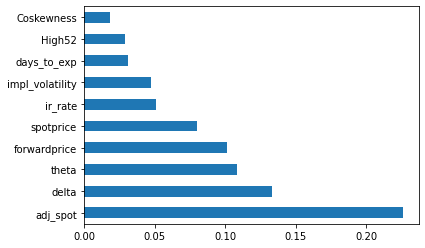

In [249]:
feat_importances = pd.Series(gbr_reg.feature_importances_, index=used_characteristics)
feat_importances.nlargest(10).plot(kind='barh')

In [250]:
X_test.sample()

,volume,ReturnSkew,MaxRet,delta,PriceDelaySlope,strike_price,IdioVol3F,ReturnSkew3F,ir_rate,mid_price,...,PriceDelayRsq,IdioVolAHT,adj_spot,vega,gamma,best_offer,DolVol,cp_flag_encoded,date_x,optionid
530009,50.0,-0.691725,-0.056886,0.612642,-0.71292,35.0,-0.020205,-0.846054,0.011254,2.3,...,0.022542,-0.023794,17.97,4.885894,0.085466,2.35,-9.32033,1.0,2003-06-30,21074852


### RF

In [260]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=3, random_state=0, 
    verbose=1)
rf_reg.fit(X_train[used_characteristics], y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.4min finished


RandomForestRegressor(max_depth=3, n_estimators=200, random_state=0, verbose=1)

In [261]:
y_pred = rf_reg.predict(X_test[used_characteristics])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


In [262]:
mean_squared_error(y_test, y_pred)

184.30435348341248

In [263]:
r2_score(y_test, y_pred)

-0.10548462935750447

In [264]:
R_squared_OSXS(y_test, y_pred)

-0.10546852985371924

<AxesSubplot:>

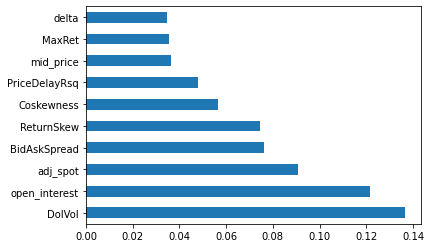

In [265]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=used_characteristics)
feat_importances.nlargest(10).plot(kind='barh')

## Backtesting

Since the $R^2$ is not very inspiring (in finance, the data is so noisy to get a good $R^2$ score), 
we want to do a backtesting based on our trained ML model. Using the so called long-short portfolio trading strategy. 


The trading strategy is defined as follows: 
1. On current month, predict next month's option return
2. Rank the option return 
3. Long the top 10, short the tail 10 (long/short the corresponding delta hedging portfolio)


In [ ]:
import matplotlib.py

In [236]:
def backtesting(test_data, regressor):
    dates = sorted(list(set(test_data.date_x)))
    hedge_from_gains = []
    for i in range(len(dates)):
        df = test_data[test_data.date_x == dates[i]]
        df = pd.DataFrame(
            {
                "secid": df.secid,
                "adj_spot": df.adj_spot,
                "strike_price": df.strike_price,
                "delta": df.delta,
                "mid_price": df.mid_price,
                "option_ret_real": df.option_ret,
                "option_ret_pred": regressor.predict(df[used_characteristics])
            }
        )
        df["hedge_cost"] = df["mid_price"] - df["adj_spot"] * df["delta"]
        df["hedge_gain"] = abs(df["hedge_cost"]) * df["option_ret_real"] 
        long_portfolio = df.sort_values(by="option_ret_pred").head(10)
        short_portfolio = df.sort_values(by="option_ret_pred").tail(10)
        short_portfolio.hedge_cost = - short_portfolio.hedge_cost
        hedge_from_gain = (sum(long_portfolio["hedge_cost"]) + sum(short_portfolio["hedge_cost"]) 
            + sum(long_portfolio["hedge_gain"]) + sum(short_portfolio["hedge_gain"]))
        hedge_from_gains.append(hedge_from_gain)
    return dates, hedge_from_gains
    

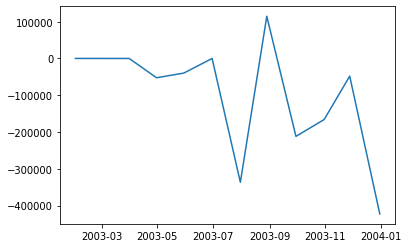

In [237]:
dates, hedge_from_gains = backtesting(test_data, lasso_reg)
plt.plot(dates, hedge_from_gains)

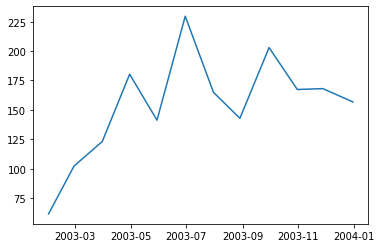

In [238]:
dates, hedge_from_gains = backtesting(test_data, ridge_reg)
plt.plot(dates, hedge_from_gains)

In [239]:
dates, hedge_from_gains = backtesting(test_data, est)
plt.plot(dates, hedge_from_gains)

NameError: name 'est' is not defined

In [75]:
import matplotlib.pyplot as plt

In [37]:
option_with_feature.columns

Index(['Unnamed: 0', 'secid', 'date_x', 'exdate', 'cp_flag', 'strike_price',
       'best_bid', 'best_offer', 'volume', 'open_interest', 'impl_volatility',
       'delta', 'gamma', 'vega', 'theta', 'optionid', 'cfadj',
       'days_no_trading', 'days_to_exp', 'forwardprice', 'spotprice',
       'adj_spot', 'ir_rate', 'mid_price', 'option_ret', 'sdate', 'edate',
       'permno', 'date2', 'yyyymm', 'Beta', 'BidAskSpread', 'Coskewness',
       'DolVol', 'High52', 'IdioRisk', 'IdioVol3F', 'IdioVolAHT', 'MaxRet',
       'PriceDelayRsq', 'PriceDelaySlope', 'PriceDelayTstat', 'ReturnSkew',
       'ReturnSkew3F', 'VolMkt', 'zerotrade', 'zerotradeAlt1', 'date_y',
       'cp_flag_encoded'],
      dtype='object')

In [38]:
option_with_feature.sort_values(by="secid")

,Unnamed: 0,secid,date_x,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,...,PriceDelayRsq,PriceDelaySlope,PriceDelayTstat,ReturnSkew,ReturnSkew3F,VolMkt,zerotrade,zerotradeAlt1,date_y,cp_flag_encoded
0,0,5015,1996-01-31,1996-07-20 00:00:00,C,20.0,4.6250,5.0000,15,25,...,0.041281,0.389311,1.212702,1.425051,1.314407,-0.083688,2.212753e-08,2.905242e-08,1996-01-01,1
2104,2104,5015,1996-01-31,1996-07-20 00:00:00,C,27.5,0.9375,1.1875,1,55,...,0.041281,0.389311,1.212702,1.425051,1.314407,-0.083688,2.212753e-08,2.905242e-08,1996-01-01,1
124598,124598,5015,1998-07-31,1998-10-17 00:00:00,P,70.0,5.8750,6.2500,5,32,...,0.062768,-0.221246,-1.163268,-0.087869,0.251508,-0.129950,1.494627e-08,1.855388e-08,1998-07-01,0
124597,124597,5015,1998-07-31,1999-01-16 00:00:00,C,70.0,4.3750,4.7500,10,35,...,0.062768,-0.221246,-1.163268,-0.087869,0.251508,-0.129950,1.494627e-08,1.855388e-08,1998-07-01,1
41988,41988,5015,1997-01-31,1997-07-19 00:00:00,P,35.0,1.3125,1.5625,10,55,...,0.381327,-1.615642,1.212702,0.190639,-1.284276,-0.081350,2.433947e-08,1.740106e-08,1997-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3168133,3168133,213212,2019-12-31,2020-08-21 00:00:00,P,17.5,0.7500,0.9000,54,33,...,0.107279,0.786024,1.873614,-0.062024,0.379443,-0.427328,8.234986e-09,1.198200e-08,2019-12-01,0
2914495,2914495,213212,2018-12-31,2019-08-16 00:00:00,C,17.5,0.4000,1.0000,28,1,...,0.055853,-0.669433,3.417680,-0.013643,0.527326,-1.600722,5.873811e-09,6.332559e-09,2018-12-01,1
2941619,2941619,213212,2019-01-31,2019-05-17 00:00:00,C,17.5,0.6500,2.4000,15,70,...,0.055853,-0.669433,3.417680,-0.179418,-0.908827,-1.341789,6.179499e-09,6.427636e-09,2019-01-01,1
3052187,3052187,213212,2019-06-28,2020-02-21 00:00:00,C,20.0,0.0500,1.5500,120,31,...,0.055853,-0.669433,3.417680,-0.194380,0.314063,-1.230118,6.836241e-09,4.644217e-09,2019-06-01,1


## DW test

In [158]:
true_pred_1vs2_return = pd.DataFrame(
    {
        "optionid": X_test.optionid,
        "time": X_test.date_x,
        "true_return": y_test,
        "pred_return1": regressor.predict(X_test[used_characteristics]),
        "pred_return2": est.predict(X_test[used_characteristics])
    }
)

In [ ]:
DW_test(true_pred_1vs2_return)